Installing the necessary extensions.

In [22]:
!pip install ngboost
!pip install scikit-learn-extra

Importing the necessary libraries.

In [23]:
import pandas as pd
import numpy as np
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score, f1_score, silhouette_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn_extra.cluster import KMedoids
from xgboost import XGBRegressor
from ngboost import NGBRegressor
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Mounting and reading the data on standard variable 'data'.

In [24]:
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/FoDS/dataset.csv'  # Replace with your file path
data = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Performing PCA on the numeric attributes of data.

In [25]:
# Loading numeric attributes of data

numeric_data = data[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']]

# Scaling the data

scaler = StandardScaler()
numeric_data_scaled = scaler.fit_transform(numeric_data)

# Performing PCA on the data

pca = PCA(n_components=3)
pca_components = pca.fit_transform(numeric_data_scaled)

# Extracting the PCA cells of pca_components

pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2', 'PC3'])

# Making a dataframe with only categorical attributes (not used in PCA)

categorical_data = data.drop(columns=['age', 'bmi', 'HbA1c_level', 'blood_glucose_level'])

# Making new dataframe with categorical attributes + PCA columns

data_pca = pd.concat([categorical_data, pca_df], axis=1)

# Statistics on the Pre-processed and Post-processed data

print("Explained Variance Ratio:", pca.explained_variance_ratio_)
print("Number of elements in data_original:", data.size)
print("Number of elements in data_pca:", data_pca.size)
print("Number of rows in data_original:", data.shape[0])
print("Number of rows in data_pca:", data_pca.shape[0])

# Printing sample cells from both data

print("\nOriginal Data (data_original):")
print(data.head())
print("\nPCA Transformed Data with Categorical Attributes (data_pca):")
print(data_pca.head())


Explained Variance Ratio: [0.448133   0.2230434  0.16659928]
Number of elements in data_original: 22500
Number of elements in data_pca: 20000
Number of rows in data_original: 2500
Number of rows in data_pca: 2500

Original Data (data_original):
   gender_number   age  hypertension  heart_disease  smoking_number    bmi  \
0              0  72.0             0              0               1  30.66   
1              1  32.0             0              0               1  39.97   
2              1  46.0             1              1               2  28.54   
3              1  74.0             0              0               0  27.32   
4              1  32.0             0              0               2  27.30   

   HbA1c_level  blood_glucose_level  diabetes  
0          4.5                  159         0  
1          7.0                  280         1  
2          5.7                  260         1  
3          5.0                  160         0  
4          5.7                  100         0 

Performing regression on blood_glucose level across other numerical attributes.

In [26]:
# Loading the dependent and independent variables for Regression

X = data[['age', 'bmi', 'HbA1c_level']]
y = data['blood_glucose_level']

# Making training and testing splits for regression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Making the function for evaluating and extracting statistics from each Regression model

def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    return rmse, mae

# Defining the models to be used

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42, max_depth=10, n_estimators=100),
    "Extra Trees": ExtraTreesRegressor(random_state=42, max_depth=10, n_estimators=100),
    "AdaBoost": AdaBoostRegressor(random_state=42, n_estimators=50),
    "XGBoost": XGBRegressor(objective='reg:squarederror', random_state=42, max_depth=5, n_estimators=100),
    "NGBoost": NGBRegressor(random_state=42, n_estimators=100, verbose =False)
}

# Storing the results in a map

results = {}
for name, model in models.items():
    rmse, mae = evaluate_model(model, X_train, X_test, y_train, y_test)
    results[name] = {"RMSE": rmse, "MAE": mae}
    print(f"{name}: RMSE = {rmse:.2f}, MAE = {mae:.2f}")

# Printing the results

results_df = pd.DataFrame(results).T
print("\nComparison of Regression Models:")
print(results_df)


Linear Regression: RMSE = 47.36, MAE = 36.56
Random Forest: RMSE = 48.24, MAE = 37.33
Extra Trees: RMSE = 48.08, MAE = 36.70
AdaBoost: RMSE = 47.91, MAE = 38.68
XGBoost: RMSE = 52.17, MAE = 40.47
NGBoost: RMSE = 47.43, MAE = 35.56

Comparison of Regression Models:
                        RMSE        MAE
Linear Regression  47.355947  36.558859
Random Forest      48.240764  37.331256
Extra Trees        48.083156  36.698548
AdaBoost           47.910267  38.676403
XGBoost            52.169931  40.474213
NGBoost            47.434920  35.557379


Testing the various classifier models accross diabetes being the column with the labels.

In [27]:
# Loading the numeric attributes to be used to predict the column of diabetes

X = data[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']]
y = data['diabetes']

# Splitting the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the data of training and testing columns (scaled to training)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Performing PCA on the training and testing columns (scaled to training)

pca = PCA(n_components=3)  # Reduce to 3 components
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Defining the classifier models to be tested

classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Naive Bayes": GaussianNB(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Linear SVM": SVC(kernel='linear'),
    "Kernel SVM": SVC(kernel='rbf'),
    "Decision Trees": DecisionTreeClassifier(),
    "Neural Networks": MLPClassifier(max_iter=1000)
}

# Defining the evalutation function for the classifiers

def evaluate_classifier(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return precision, recall, f1

# Printing the statistics on the evalutation models (on both pre-processed and post-processed data)

print("Evaluation on Original Dataset (without PCA):")
results_original = {}
for name, model in classifiers.items():
    precision, recall, f1 = evaluate_classifier(model, X_train, X_test, y_train, y_test)
    results_original[name] = {"Precision": precision, "Recall": recall, "F1-score": f1}
    print(f"{name}: Precision = {precision:.2f}, Recall = {recall:.2f}, F1-score = {f1:.2f}")

print("\nEvaluation on Pre-processed Dataset (with PCA):")
results_pca = {}
for name, model in classifiers.items():
    precision, recall, f1 = evaluate_classifier(model, X_train_pca, X_test_pca, y_train, y_test)
    results_pca[name] = {"Precision": precision, "Recall": recall, "F1-score": f1}
    print(f"{name}: Precision = {precision:.2f}, Recall = {recall:.2f}, F1-score = {f1:.2f}")

# Storing the results

results_original_df = pd.DataFrame(results_original).T
results_pca_df = pd.DataFrame(results_pca).T

# Printing the results

print("\nComparison of Classifiers on Original and PCA Datasets:")
comparison_df = pd.concat([results_original_df, results_pca_df], axis=1, keys=['Original Dataset', 'PCA Dataset'])
print(comparison_df)

Evaluation on Original Dataset (without PCA):
Logistic Regression: Precision = 0.87, Recall = 0.74, F1-score = 0.80
Naive Bayes: Precision = 0.88, Recall = 0.68, F1-score = 0.77
K-Nearest Neighbors: Precision = 0.80, Recall = 0.63, F1-score = 0.71
Linear SVM: Precision = 0.88, Recall = 0.72, F1-score = 0.79
Kernel SVM: Precision = 0.91, Recall = 0.41, F1-score = 0.57
Decision Trees: Precision = 0.86, Recall = 0.78, F1-score = 0.82
Neural Networks: Precision = 0.92, Recall = 0.59, F1-score = 0.72

Evaluation on Pre-processed Dataset (with PCA):
Logistic Regression: Precision = 0.86, Recall = 0.75, F1-score = 0.80
Naive Bayes: Precision = 0.88, Recall = 0.63, F1-score = 0.74
K-Nearest Neighbors: Precision = 0.86, Recall = 0.78, F1-score = 0.82
Linear SVM: Precision = 0.88, Recall = 0.72, F1-score = 0.79
Kernel SVM: Precision = 0.91, Recall = 0.72, F1-score = 0.80
Decision Trees: Precision = 0.78, Recall = 0.72, F1-score = 0.75
Neural Networks: Precision = 0.89, Recall = 0.77, F1-score = 

K-means (Z-score) optimal k: 5, Silhouette Score: 0.25633023718754994, Dunn's Index: 0.01422654384564613, BetaCV: 1.664474415617827
EM (Z-score) optimal k: 2, Silhouette Score: 0.25031471060388155, Dunn's Index: 0.00991247254214469, BetaCV: 1.2949568435784609
K-Medoids (Z-score) optimal k: 2, Silhouette Score: 0.27770090824526067, Dunn's Index: 0.00997968812188863, BetaCV: 1.3819201318969387

K-means (Original) optimal k: 2, Silhouette Score: 0.5633119700228013, Dunn's Index: 0.3086038628023076, BetaCV: 2.283016158030743
EM (Original) optimal k: 3, Silhouette Score: 0.4674627762737606, Dunn's Index: 0.20059251082149962, BetaCV: 2.4156280180297793
K-Medoids (Original) optimal k: 2, Silhouette Score: 0.5704125688705957, Dunn's Index: 0.01857702053894427, BetaCV: 2.4930867468162936

Clustering Comparison with Optimal k:
      Clustering Method  Optimal k  Silhouette Score  Dunn's Index    BetaCV
0     K-means (Z-score)          5          0.256330      0.014227  1.664474
1          EM (Z-

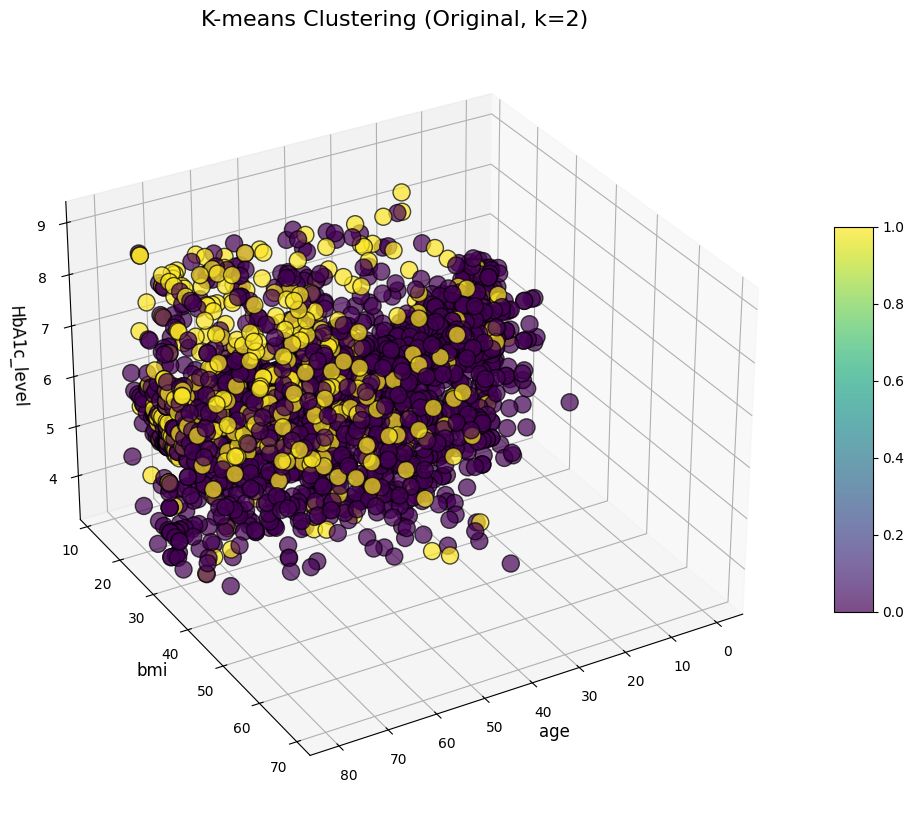

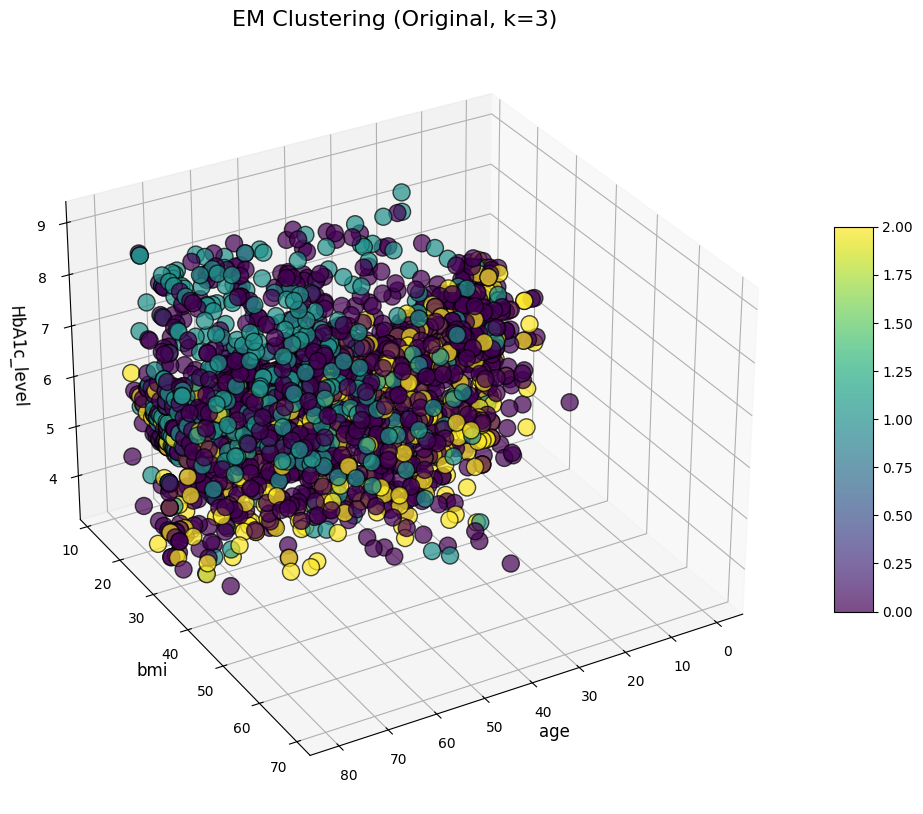

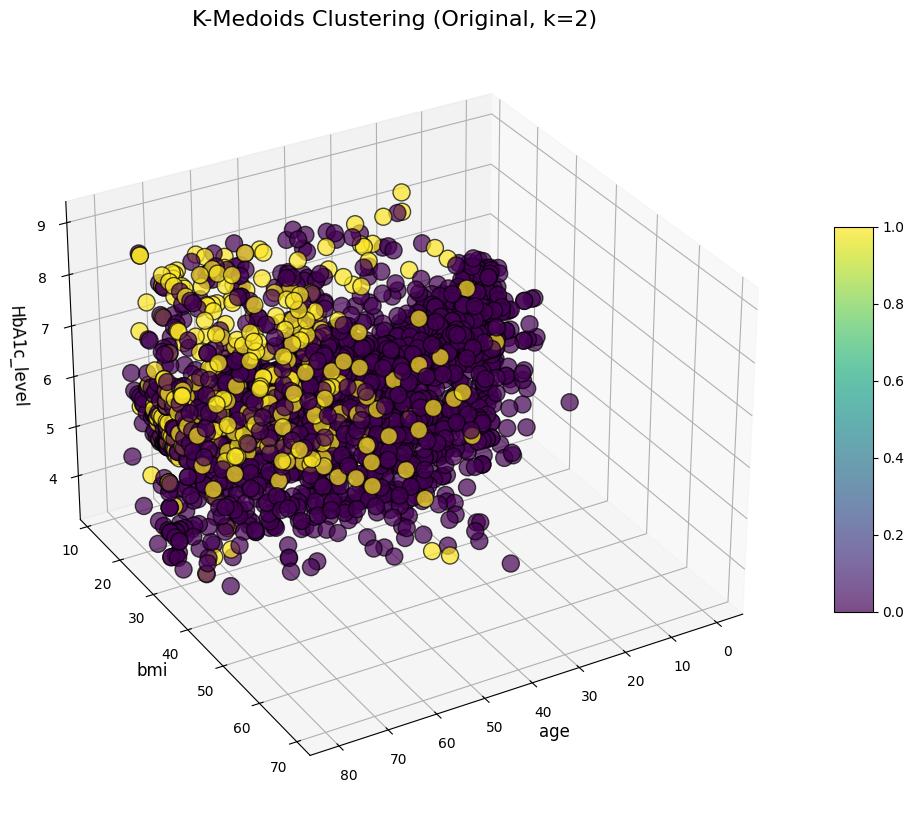

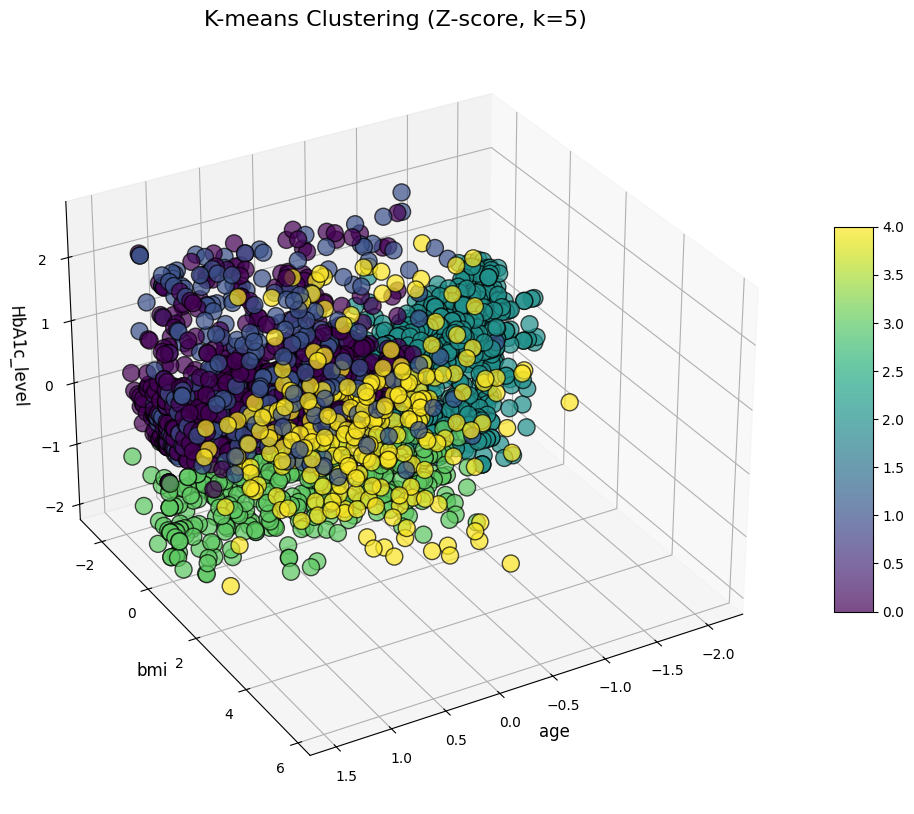

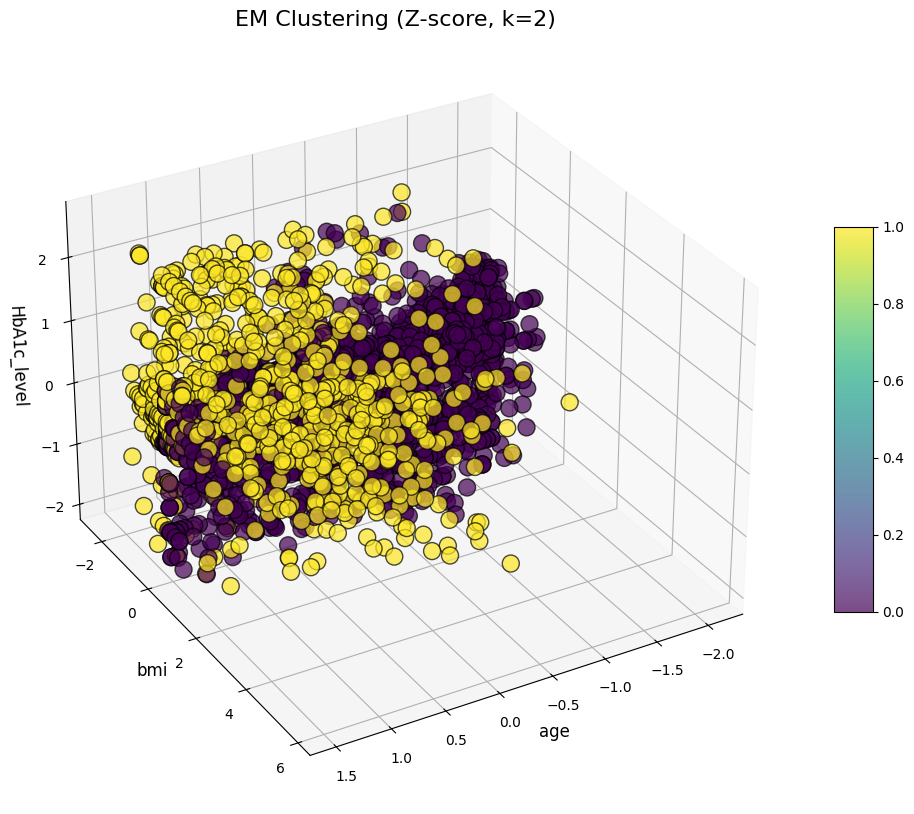

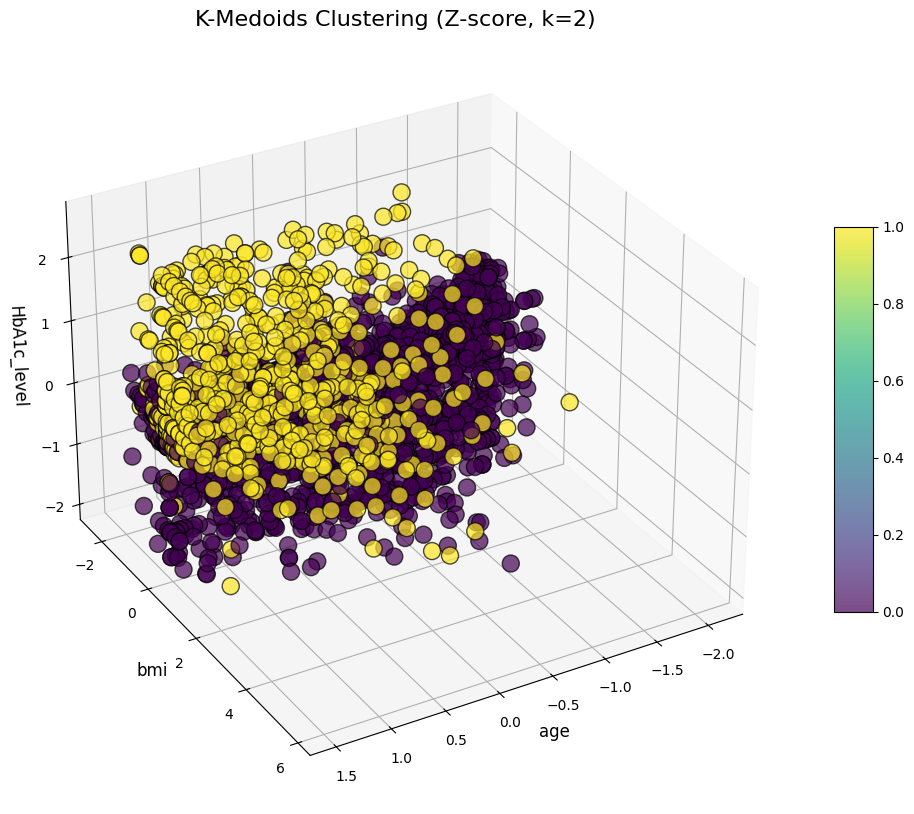

In [34]:
# Load the numeric attributes to be used for clustering

X = data[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']]

# Scale the data

scaler = StandardScaler()
X_zscore = scaler.fit_transform(X)

# Function to calculate optimal k using silhouette scores

def find_optimal_k(X, clustering_func, k_range):
    best_k = k_range[0]
    best_silhouette = -1
    for k in k_range:
        try:
            labels = clustering_func(X, k)
            silhouette = silhouette_score(X, labels)
            if silhouette > best_silhouette:
                best_silhouette = silhouette
                best_k = k
        except:
            continue
    return best_k, best_silhouette

# Clustering functions

def kmeans_clustering(X, k):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    labels = kmeans.labels_
    return labels, kmeans.inertia_

def em_clustering(X, k):
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X)
    labels = gmm.predict(X)
    return labels

def kmedoids_clustering(X, k):
    kmedoids = KMedoids(n_clusters=k, init='k-medoids++', random_state=42)
    kmedoids.fit(X)
    labels = kmedoids.labels_
    return labels

# Calculate Dunn's Index

def dunn_index(X, labels):
    distances = pairwise_distances(X)
    intra_cluster_distances = []
    inter_cluster_distances = []
    for label in np.unique(labels):
        cluster_points = X[labels == label]
        # Calculate the maximum intra-cluster distance
        intra_cluster_distances.append(np.max(pairwise_distances(cluster_points)))
        for other_label in np.unique(labels):
            if label != other_label:
                other_cluster_points = X[labels == other_label]
                # Calculate the minimum inter-cluster distance
                inter_cluster_distances.append(np.min(pairwise_distances(cluster_points, other_cluster_points)))
    return np.min(inter_cluster_distances) / np.max(intra_cluster_distances)

# Compute BetaCV (Cross-Validation Metric)

def beta_cv(X, labels):
    pairwise_dist = pairwise_distances(X)
    intra_cluster_distances = np.array([np.mean(pairwise_dist[labels == label, :][:, labels == label]) for label in np.unique(labels)])
    inter_cluster_distances = np.array([np.mean(pairwise_dist[labels == label, :][:, labels != label]) for label in np.unique(labels)])
    return np.mean(inter_cluster_distances) / np.mean(intra_cluster_distances)

# Find the optimal k and evaluate clustering

k_range = range(2, 11)

# For Z-score transformed data (X_zscore)

optimal_k_kmeans_zscore, best_silhouette_kmeans_zscore = find_optimal_k(X_zscore, lambda X, k: kmeans_clustering(X, k)[0], k_range)
optimal_k_em_zscore, best_silhouette_em_zscore = find_optimal_k(X_zscore, em_clustering, k_range)
optimal_k_kmedoids_zscore, best_silhouette_kmedoids_zscore = find_optimal_k(X_zscore, kmedoids_clustering, k_range)

# For original data (X)

optimal_k_kmeans, best_silhouette_kmeans = find_optimal_k(X, lambda X, k: kmeans_clustering(X, k)[0], k_range)
optimal_k_em, best_silhouette_em = find_optimal_k(X, em_clustering, k_range)
optimal_k_kmedoids, best_silhouette_kmedoids = find_optimal_k(X, kmedoids_clustering, k_range)

# Apply optimal k to clustering models and get labels (for both datasets)

labels_kmeans_zscore, sse_kmeans_zscore = kmeans_clustering(X_zscore, optimal_k_kmeans_zscore)
labels_em_zscore = em_clustering(X_zscore, optimal_k_em_zscore)
labels_kmedoids_zscore = kmedoids_clustering(X_zscore, optimal_k_kmedoids_zscore)

labels_kmeans, sse_kmeans = kmeans_clustering(X, optimal_k_kmeans)
labels_em = em_clustering(X, optimal_k_em)
labels_kmedoids = kmedoids_clustering(X, optimal_k_kmedoids)

# Calculate metrics for Z-score transformed data

dunn_kmeans_zscore = dunn_index(X_zscore, labels_kmeans_zscore)
beta_cv_kmeans_zscore = beta_cv(X_zscore, labels_kmeans_zscore)

dunn_em_zscore = dunn_index(X_zscore, labels_em_zscore)
beta_cv_em_zscore = beta_cv(X_zscore, labels_em_zscore)

dunn_kmedoids_zscore = dunn_index(X_zscore, labels_kmedoids_zscore)
beta_cv_kmedoids_zscore = beta_cv(X_zscore, labels_kmedoids_zscore)

# Calculate metrics for original data

dunn_kmeans = dunn_index(X, labels_kmeans)
beta_cv_kmeans = beta_cv(X, labels_kmeans)

dunn_em = dunn_index(X, labels_em)
beta_cv_em = beta_cv(X, labels_em)

dunn_kmedoids = dunn_index(X, labels_kmedoids)
beta_cv_kmedoids = beta_cv(X, labels_kmedoids)

# Print results

print(f"K-means (Z-score) optimal k: {optimal_k_kmeans_zscore}, Silhouette Score: {best_silhouette_kmeans_zscore}, Dunn's Index: {dunn_kmeans_zscore}, BetaCV: {beta_cv_kmeans_zscore}")
print(f"EM (Z-score) optimal k: {optimal_k_em_zscore}, Silhouette Score: {best_silhouette_em_zscore}, Dunn's Index: {dunn_em_zscore}, BetaCV: {beta_cv_em_zscore}")
print(f"K-Medoids (Z-score) optimal k: {optimal_k_kmedoids_zscore}, Silhouette Score: {best_silhouette_kmedoids_zscore}, Dunn's Index: {dunn_kmedoids_zscore}, BetaCV: {beta_cv_kmedoids_zscore}")

print(f"\nK-means (Original) optimal k: {optimal_k_kmeans}, Silhouette Score: {best_silhouette_kmeans}, Dunn's Index: {dunn_kmeans}, BetaCV: {beta_cv_kmeans}")
print(f"EM (Original) optimal k: {optimal_k_em}, Silhouette Score: {best_silhouette_em}, Dunn's Index: {dunn_em}, BetaCV: {beta_cv_em}")
print(f"K-Medoids (Original) optimal k: {optimal_k_kmedoids}, Silhouette Score: {best_silhouette_kmedoids}, Dunn's Index: {dunn_kmedoids}, BetaCV: {beta_cv_kmedoids}")

# Store the results in a DataFrame for easier viewing

results = {
    'Clustering Method': ['K-means (Z-score)', 'EM (Z-score)', 'K-medoids (Z-score)', 'K-means (Original)', 'EM (Original)', 'K-medoids (Original)'],
    'Optimal k': [optimal_k_kmeans_zscore, optimal_k_em_zscore, optimal_k_kmedoids_zscore, optimal_k_kmeans, optimal_k_em, optimal_k_kmedoids],
    'Silhouette Score': [best_silhouette_kmeans_zscore, best_silhouette_em_zscore, best_silhouette_kmedoids_zscore, best_silhouette_kmeans, best_silhouette_em, best_silhouette_kmedoids],
    'Dunn\'s Index': [dunn_kmeans_zscore, dunn_em_zscore, dunn_kmedoids_zscore, dunn_kmeans, dunn_em, dunn_kmedoids],
    'BetaCV': [beta_cv_kmeans_zscore, beta_cv_em_zscore, beta_cv_kmedoids_zscore, beta_cv_kmeans, beta_cv_em, beta_cv_kmedoids]
}
results_df = pd.DataFrame(results)
print("\nClustering Comparison with Optimal k:")
print(results_df)

# Ensure that the data is in NumPy array format for clustering and plotting

X_values = X_zscore.values if isinstance(X_zscore, pd.DataFrame) else X_zscore
X_original_values = X.values if isinstance(X, pd.DataFrame) else X

# Function to plot clusters in 3D for both original and Z-score data

def plot_clusters_3d(X, labels, title, feature_names):
    # Create a 3D plot
    fig = plt.figure(figsize=(14, 10))  # Increase figure size for better visibility
    ax = fig.add_subplot(111, projection='3d')

    # If X is a DataFrame, convert to NumPy array
    if isinstance(X, pd.DataFrame):
        X = X.values

    # Plot only the first three features for 3D visualization
    scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels, cmap='viridis', s=150, alpha=0.7, edgecolors='k')

    # Set axis labels to reflect the feature names
    ax.set_title(title, fontsize=16)
    ax.set_xlabel(feature_names[0], fontsize=12)  # First feature name
    ax.set_ylabel(feature_names[1], fontsize=12)  # Second feature name
    ax.set_zlabel(feature_names[2], fontsize=12)  # Third feature name

    # Adjust the view angle to ensure all clusters are visible
    ax.view_init(elev=30., azim=60)  # Adjust the viewing angle for better visibility of the third label

    # Add color bar to indicate the cluster labels
    fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=10)

    # Show the plot
    plt.show()

# List of feature names for visualization

feature_names = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']

# For 3D plot, we will use the first three features (you can change this if desired)

X_3d_values_original = X_original_values[:, :3]  # Use the first three columns of the original data
X_3d_values_zscore = X_zscore[:, :3]  # Use the first three columns of the Z-score transformed data

# Plot clustering results in 3D with optimal k values for both datasets

print("\nClustering 3D plots with optimal k values:")

# Original data clustering plots

plot_clusters_3d(X_3d_values_original, labels_kmeans, f'K-means Clustering (Original, k={optimal_k_kmeans})', feature_names)
plot_clusters_3d(X_3d_values_original, labels_em, f'EM Clustering (Original, k={optimal_k_em})', feature_names)
plot_clusters_3d(X_3d_values_original, labels_kmedoids, f'K-Medoids Clustering (Original, k={optimal_k_kmedoids})', feature_names)

# Z-score data clustering plots

plot_clusters_3d(X_3d_values_zscore, labels_kmeans_zscore, f'K-means Clustering (Z-score, k={optimal_k_kmeans_zscore})', feature_names)
plot_clusters_3d(X_3d_values_zscore, labels_em_zscore, f'EM Clustering (Z-score, k={optimal_k_em_zscore})', feature_names)
plot_clusters_3d(X_3d_values_zscore, labels_kmedoids_zscore, f'K-Medoids Clustering (Z-score, k={optimal_k_kmedoids_zscore})', feature_names)